Code to run IRI/MSIS and the RRMN model to simulate ICON FUV observations and replace the data in a L1 file. Used on the Memorial Day simulation to replace noise measurements with simulated data so we can get Scott a multi-day L2.5 file.

Note that our current FUV forward model does not use the updated/correct sensitivity value (the one published in Mende et al.). So, the simulation is not expected to be as representative of reality as if we had asked Scott et al to run the instrument model. However, for what Scott is looking to do, this is not a problem (it is realistic enough).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import FUV_L2
reload(FUV_L2)
import ICON_FUV_fwd_model as FUV_F # for simulating data
reload(FUV_F)
import netCDF4
from dateutil import parser

In [3]:
file_input='/home/jmakela/Projects/ICON/FUV/ICON_L1_FUV_SWP_2017-05-29_v01r000.NC'
file_ancillary='/home/jmakela/Projects/ICON/FUV/ICON_L0P_FUV_ANCILLARY_2017-05-29_v01r000.NC'
file_GPI = '/home/jmakela/Projects/ICON/FUV/ICON_Ancillary_GPI_2015-001_to_2017-199_v01r000.NC'

In [6]:
gpi = netCDF4.Dataset(file_GPI,mode='r')
if 'f107d' in gpi.variables.keys():
    print 'yes'
else:
    print 'no'

yes


In [ ]:
# Open input Level 1 and ancillary NetCDF files
data = netCDF4.Dataset(file_input,mode='r+')
ancillary = netCDF4.Dataset(file_ancillary,mode='r')

if file_GPI is not None:
    gpi = netCDF4.Dataset(file_GPI,mode='r')

    # Read the geophysical indeces
    ap3 = gpi['ap3'][:]
    ap = gpi['ap'][:]
    year_day = gpi['year_day'][:]
    f107 = gpi['f107d'][:]
    f107a = gpi['f107d'][:]  ### replaced f107a with f107d because the provided GPI does not have f107a
else:
    ap3 = None
    ap = None
    year_day = None
    f107 = None
    f107a = None

# The tangent point WGS-84 coordinates at the center of the integration time
FUV_TANGENT_WGS = ancillary.variables['ICON_ANCILLARY_FUV_TANGENTPOINTS_LATLONALT'][:,:,:,:]
FUV_TANGENT_LATITUDES = ancillary.variables['ICON_ANCILLARY_FUV_TANGENTPOINTS_LATLONALT'][:,:,:,0]
FUV_TANGENT_LONGITUDES = ancillary.variables['ICON_ANCILLARY_FUV_TANGENTPOINTS_LATLONALT'][:,:,:,1]
FUV_TANGENT_ALTITUDES = ancillary.variables['ICON_ANCILLARY_FUV_TANGENTPOINTS_LATLONALT'][:,:,:,2]

# The az/el of the look vector
FUV_AZ = ancillary.variables['ICON_ANCILLARY_FUV_FOV_AZIMUTH_ANGLE'][:,:,:]
FUV_ZE = ancillary.variables['ICON_ANCILLARY_FUV_FOV_ZENITH_ANGLE'][:,:,:]

# The ICON WGS-84 location at the center of the integration time
ICON_WGS84_LATITUDE = ancillary.variables['ICON_ANCILLARY_FUV_LATITUDE'][:]
ICON_WGS84_LONGITUDE = ancillary.variables['ICON_ANCILLARY_FUV_LONGITUDE'][:]
ICON_WGS84_ALTITUDE = ancillary.variables['ICON_ANCILLARY_FUV_ALTITUDE'][:]

# Read the UTC of all measurements and store in a datetime variable
temp = ancillary.variables['ICON_ANCILLARY_FUV_TIME_UTC']
ANC_dn = []
for d in temp:
    ANC_dn.append(parser.parse(d))
ANC_dn = np.array(ANC_dn)

# Get Data from file.
# L1 data stores the individual stripes in different variables. Read them
# all stripes and combine into a single variable
mirror_dir = ['M9','M6','M3','P0','P3','P6']
FUV_1356_IMAGE = np.zeros(np.shape(FUV_AZ))
FUV_1356_ERROR = np.zeros(np.shape(FUV_AZ))
for ind, d in enumerate(mirror_dir):
    FUV_1356_IMAGE[:,:,ind] = data.variables['ICON_L1_FUVA_SWP_PROF_%s' % d][:]
    FUV_1356_ERROR[:,:,ind] = data.variables['ICON_L1_FUVA_SWP_PROF_%s_ERROR' % d][:]

# Get observation times from file and store in a datetime variable
temp = data.variables['ICON_L1_FUVA_SWP_CENTER_TIMES']
FUV_dn = []
for d in temp:
    FUV_dn.append(parser.parse(d))
FUV_dn = np.array(FUV_dn)

# Get science mode
FUV_mode = data.variables['ICON_L1_FUVA_SWP_MODE'][:]

In [ ]:
for sample in arange(3547,len(FUV_AZ)):
    print '%d/%d' % (sample, len(FUV_mode))
    I_nn = zeros([256,6])
    I_n = zeros([256,6])
    phot_nn = zeros([256,6])

    if FUV_mode[sample] == 2:
        for stripe in range(6):
            ze = np.squeeze(FUV_ZE[sample,:,stripe])
            az = np.squeeze(FUV_AZ[sample,:,stripe])
            satlat = ICON_WGS84_LATITUDE[sample]
            satlon = ICON_WGS84_LONGITUDE[sample]
            satalt = ICON_WGS84_ALTITUDE[sample]
            dn = ANC_dn[sample]
            my_f107, my_f107a, my_apmsis = FUV_L2.get_msisGPI(dn, year_day, f107, f107a, ap, ap3)
            sym_sph = 1

            I_nn[:,stripe], phot_nn[:,stripe] = FUV_F.get_Photons_from_Brightness_Profile_1356_nighttime(ze,az,satlat,satlon,satalt,dn,
                                                                                     cont=1,
                                                                                     symmetry =1, # 0 = spherical symmetry
                                                                                     shperical=1, # 0 = spherical earth
                                                                                     step = 100., # step size for line-of-sight integral. Larger --> runs faster
                                                                                     f107=my_f107, 
                                                                                     f107a=my_f107a, 
                                                                                     apmsis=my_apmsis,
                                                                                     stripes_used=1)

            temp, xx = FUV_F.add_noise_to_photon_and_brightness(phot_nn[:,stripe],stripes_used=1)
            I_n[:,stripe] = temp[0,:] # only use first realization

            # replace values
            data.variables['ICON_L1_FUVA_SWP_PROF_%s' % mirror_dir[stripe]][sample,:] = I_n[:,0]
            data.variables['ICON_L1_FUVA_SWP_PROF_%s_ERROR' % mirror_dir[stripe]][sample,:] = sqrt(I_nn[:,0])

data.close()

3547/4960
3548/4960
3549/4960
3550/4960
3551/4960
3552/4960
3553/4960
3554/4960
3555/4960
3556/4960
3557/4960
3558/4960
3559/4960
3560/4960
3561/4960
3562/4960
3563/4960
3564/4960
3565/4960
3566/4960
3567/4960
3568/4960
3569/4960
3570/4960
3571/4960
3572/4960
3573/4960
3574/4960
3575/4960
3576/4960
3577/4960
3578/4960
3579/4960
3580/4960
3581/4960
3582/4960
3583/4960
3584/4960
3585/4960
3586/4960
3587/4960
3588/4960
3589/4960
3590/4960
3591/4960
3592/4960
3593/4960
3594/4960
3595/4960
3596/4960
3597/4960
3598/4960
3599/4960
3600/4960
3601/4960
3602/4960
3603/4960
3604/4960
3605/4960
3606/4960
3607/4960
3608/4960
3609/4960
3610/4960
3611/4960
3612/4960
3613/4960
3614/4960
3615/4960
3616/4960
3617/4960
3618/4960
3619/4960
3620/4960
3621/4960
3622/4960
3623/4960
3624/4960
3625/4960
3626/4960
3627/4960
3628/4960
3629/4960
3630/4960
3631/4960
3632/4960
3633/4960
3634/4960
3635/4960
3636/4960
3637/4960
3638/4960
3639/4960
3640/4960
3641/4960
3642/4960
3643/4960
3644/4960
3645/4960
3646/4960


4620/4960
4621/4960
4622/4960
4623/4960
4624/4960
4625/4960
4626/4960
4627/4960
4628/4960
4629/4960
4630/4960
4631/4960
4632/4960
4633/4960
4634/4960
4635/4960
4636/4960
4637/4960
4638/4960
4639/4960
4640/4960
4641/4960
4642/4960
4643/4960
4644/4960
4645/4960
4646/4960
4647/4960
4648/4960
4649/4960
4650/4960
4651/4960
4652/4960
4653/4960
4654/4960
4655/4960
4656/4960
4657/4960
4658/4960
4659/4960
4660/4960
4661/4960
4662/4960
4663/4960
4664/4960
4665/4960
4666/4960
4667/4960
4668/4960


In [10]:
print sample

4959


In [11]:
data.close()

RuntimeError: NetCDF: Not a valid ID

4959
[ 678  679  680 ..., 5933 5934 5935]


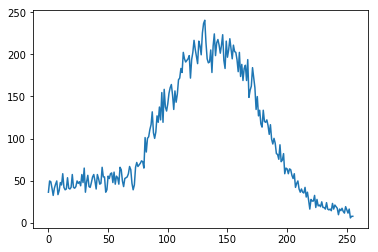

In [12]:
data = netCDF4.Dataset(file_input,mode='r+')
plot(data.variables['ICON_L1_FUVA_SWP_PROF_%s' % mirror_dir[stripe]][sample-1,:])
data.close()
print sample
print arange(678,5936)